<a href="https://colab.research.google.com/github/MeghanaKiran77/Sequential-Pattern-Mining-using-PrefixSpan-GSP-SPADE/blob/main/Sequential_Pattern_Mining_(1)_DWDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
import shutil  # To rename/move the file

# Upload the file
uploaded = files.upload()

# Get the uploaded filename (automatically fetches the name)
for filename in uploaded.keys():
    original_filename = filename
    break  # In case you upload more than one, we take the first one

# Define your new, fixed filename
new_filename = "user_travel_sequences.csv"

# Rename the uploaded file to your fixed name
shutil.move(original_filename, new_filename)

print(f"File successfully renamed to: {new_filename}")


Saving user_travel_sequences.csv to user_travel_sequences (4).csv
File successfully renamed to: user_travel_sequences.csv


In [1]:
import pandas as pd

df = pd.read_csv('user_travel_sequences.csv')
print(df.head())


  user_id        date      time  location_name  latitude  longitude  \
0    U001  2025-03-01  08:00 AM        Library   17.4123    78.4321   
1    U001  2025-03-01  09:00 AM  Grocery Store   17.4180    78.4345   
2    U001  2025-03-01  10:00 AM     Restaurant   17.4201    78.4367   
3    U001  2025-03-01  11:30 AM         School   17.4260    78.4380   
4    U001  2025-03-01  13:00 PM       Bus Stop   17.4285    78.4402   

  transport_mode  
0           Walk  
1           Auto  
2           Auto  
3            Bus  
4           Walk  


In [2]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv("user_travel_sequences.csv")

# ✅ Fix invalid PM/AM like "13:00 PM" → "01:00 PM"
def fix_time_format(t):
    t = t.strip()
    match = re.match(r'(\d{2}):(\d{2})\s*(AM|PM)', t, re.IGNORECASE)
    if match:
        hour, minute, period = match.groups()
        hour = int(hour)
        # Convert to 12-hour format if needed
        if hour > 12:
            hour -= 12
        return f"{hour:02}:{minute} {period.upper()}"
    return t  # return as-is if it doesn't match pattern

df["time"] = df["time"].apply(fix_time_format)

# ✅ Convert cleaned time to datetime.time
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%Y-%m-%d %I:%M %p")
df = df.sort_values(by=["user_id", "datetime"])

# ✅ Group by user and date to get daily sequences
user_sequences = df.groupby(["user_id", df["datetime"].dt.date])["location_name"].apply(list).reset_index()

# ✅ Group again by user to get list of sequences
final_sequences = user_sequences.groupby("user_id")["location_name"].apply(list).to_dict()

# ✅ Print results
for user, sequences in final_sequences.items():
    print(f"\nUser {user}:")
    for seq in sequences:
        print(" → ".join(seq))



User U001:
Library → Grocery Store → Restaurant → School → Bus Stop
Gym → Playground
Cafe → Mall → Home → Restaurant
Office → Coffee Shop → School
Bus Stop → Cafe
Gym → School → Cafe → Coffee Shop → Metro Station
Playground → Coffee Shop → Library

User U002:
School → Office → Restaurant → Cafe → Bus Stop
Bus Stop → Mall → Metro Station → Playground
Home → Office → Metro Station
Playground → Gym → Home → Mall
Playground → Mall → Library
Bus Stop → Grocery Store
Restaurant → Home → Bus Stop
Gym → Office → Cafe → Playground → Metro Station
Metro Station → Coffee Shop

User U003:
Office → Grocery Store → Gym → Playground → Restaurant
Metro Station → Bus Stop → Restaurant → Grocery Store
Library → Bus Stop → Gym → School → Home
Coffee Shop → School
Coffee Shop → Library
Restaurant → Metro Station → Playground → Library
Metro Station → Cafe → Bus Stop

User U004:
Coffee Shop → School → Home
Mall → Cafe → Gym → Playground
Bus Stop → Restaurant → Home → Office → Grocery Store
Playground → Ma

In [16]:
# Flatten all user sequences into a single list of sequences
all_sequences = []
for user, sequences in final_sequences.items():
    all_sequences.extend(sequences)

import pprint
pprint.pprint(all_sequences)


[['Library', 'Grocery Store', 'Restaurant', 'School', 'Bus Stop'],
 ['Gym', 'Playground'],
 ['Cafe', 'Mall', 'Home', 'Restaurant'],
 ['Office', 'Coffee Shop', 'School'],
 ['Bus Stop', 'Cafe'],
 ['Gym', 'School', 'Cafe', 'Coffee Shop', 'Metro Station'],
 ['Playground', 'Coffee Shop', 'Library'],
 ['School', 'Office', 'Restaurant', 'Cafe', 'Bus Stop'],
 ['Bus Stop', 'Mall', 'Metro Station', 'Playground'],
 ['Home', 'Office', 'Metro Station'],
 ['Playground', 'Gym', 'Home', 'Mall'],
 ['Playground', 'Mall', 'Library'],
 ['Bus Stop', 'Grocery Store'],
 ['Restaurant', 'Home', 'Bus Stop'],
 ['Gym', 'Office', 'Cafe', 'Playground', 'Metro Station'],
 ['Metro Station', 'Coffee Shop'],
 ['Office', 'Grocery Store', 'Gym', 'Playground', 'Restaurant'],
 ['Metro Station', 'Bus Stop', 'Restaurant', 'Grocery Store'],
 ['Library', 'Bus Stop', 'Gym', 'School', 'Home'],
 ['Coffee Shop', 'School'],
 ['Coffee Shop', 'Library'],
 ['Restaurant', 'Metro Station', 'Playground', 'Library'],
 ['Metro Station', 'C

In [18]:
import pickle

with open("all_sequences.pkl", "wb") as f:
    pickle.dump(all_sequences, f)


In [19]:
with open("all_sequences.pkl", "rb") as f:
    all_sequences = pickle.load(f)

In [28]:
from prefixspan import PrefixSpan

# Initialize the PrefixSpan object with your sequences
ps = PrefixSpan(all_sequences)

# Get frequent patterns with minimum support = 2
frequent_patterns = ps.frequent(3)

# Filter out single-item sequences
filtered_patterns = [pattern for pattern in frequent_patterns if len(pattern[1]) >= 2]

# Sort by support in descending order
filtered_patterns.sort(reverse=True, key=lambda x: x[0])

# Print results
print("Most frequent patterns with min_support = 2, are as follows:")
for support, sequence in filtered_patterns:
    print(f"Support: {support} | Sequence: {sequence}")


Most frequent patterns with min_support = 2, are as follows:
Support: 6 | Sequence: ['Bus Stop', 'Grocery Store']
Support: 5 | Sequence: ['Grocery Store', 'Bus Stop']
Support: 5 | Sequence: ['Grocery Store', 'Gym']
Support: 5 | Sequence: ['Restaurant', 'Bus Stop']
Support: 5 | Sequence: ['School', 'Bus Stop']
Support: 4 | Sequence: ['Library', 'Restaurant']
Support: 4 | Sequence: ['Grocery Store', 'School']
Support: 4 | Sequence: ['Restaurant', 'Grocery Store']
Support: 4 | Sequence: ['School', 'Restaurant']
Support: 4 | Sequence: ['School', 'Gym']
Support: 4 | Sequence: ['Bus Stop', 'Cafe']
Support: 4 | Sequence: ['Bus Stop', 'Restaurant']
Support: 4 | Sequence: ['Bus Stop', 'Gym']
Support: 4 | Sequence: ['Gym', 'Playground']
Support: 4 | Sequence: ['Gym', 'Restaurant']
Support: 4 | Sequence: ['Playground', 'Mall']
Support: 4 | Sequence: ['Playground', 'Cafe']
Support: 4 | Sequence: ['Cafe', 'Restaurant']
Support: 4 | Sequence: ['Mall', 'Cafe']
Support: 4 | Sequence: ['Home', 'Restaur

In [28]:
from prefixspan import PrefixSpan

# Set the number of top patterns you want to see
K = 10  # Change this to any number you like

# Initialize the PrefixSpan object with your sequences
ps = PrefixSpan(all_sequences)

# Get frequent patterns with minimum support = 2
frequent_patterns = ps.frequent(2)

# Filter out single-item sequences
filtered_patterns = [pattern for pattern in frequent_patterns if len(pattern[1]) >= 2]

# Sort by support in descending order
filtered_patterns.sort(reverse=True, key=lambda x: x[0])

# Get top-K patterns
top_k_patterns = filtered_patterns[:K]

# Print results
print(f"Top {K} frequent sequential patterns:\n")
for support, sequence in top_k_patterns:
    print(f"Support: {support} | Sequence: {sequence}")


Top 10 frequent sequential patterns:

Support: 6 | Sequence: ['Bus Stop', 'Grocery Store']
Support: 5 | Sequence: ['Grocery Store', 'Bus Stop']
Support: 5 | Sequence: ['Grocery Store', 'Gym']
Support: 5 | Sequence: ['Restaurant', 'Bus Stop']
Support: 5 | Sequence: ['School', 'Bus Stop']
Support: 4 | Sequence: ['Library', 'Restaurant']
Support: 4 | Sequence: ['Grocery Store', 'School']
Support: 4 | Sequence: ['Restaurant', 'Grocery Store']
Support: 4 | Sequence: ['School', 'Restaurant']
Support: 4 | Sequence: ['School', 'Gym']


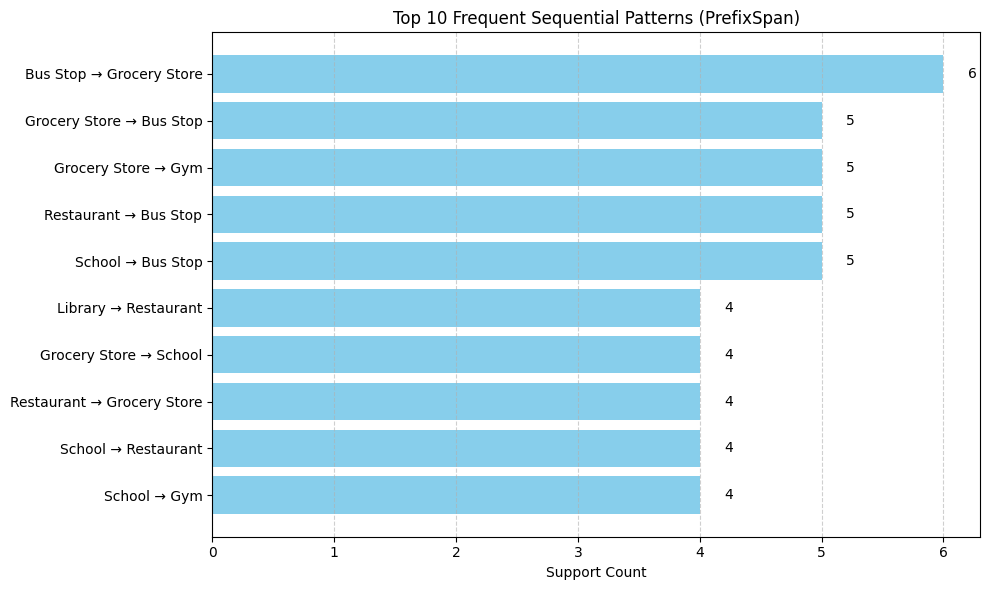

In [29]:
import matplotlib.pyplot as plt

# Extract support and pattern strings
supports = [support for support, sequence in top_k_patterns]
sequences = [' → '.join(sequence) for support, sequence in top_k_patterns]

# Reverse for top-down plotting
supports = supports[::-1]
sequences = sequences[::-1]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sequences, supports, color='skyblue')
plt.xlabel("Support Count")
plt.title(f"Top {K} Frequent Sequential Patterns (PrefixSpan)")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars with support values
for bar, support in zip(bars, supports):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, str(support), va='center')

plt.tight_layout()
plt.show()


In [30]:
from prefixspan import PrefixSpan

# Set the number of top patterns you want to see
K = 10  # Change this as needed

# Initialize PrefixSpan with sequences
ps = PrefixSpan(all_sequences)

# Get frequent patterns with minimum support
frequent_patterns = ps.frequent(2)

# Step 1: Filter and sort by support (descending)
sorted_patterns = sorted(
    [p for p in frequent_patterns if len(p[1]) >= 2],
    key=lambda x: x[0], reverse=True
)

# Step 2: Find the support of the K-th pattern
threshold_support = sorted_patterns[K - 1][0]

# Step 3: Include all patterns with support >= threshold_support
top_k_or_more = [p for p in sorted_patterns if p[0] >= threshold_support]

# Step 4: Print the result
print(f"Top patterns with support ≥ {threshold_support} (K={K} cutoff):\n")
for support, sequence in top_k_or_more:
    print(f"Support: {support} | Sequence: {sequence}")


Top patterns with support ≥ 4 (K=10 cutoff):

Support: 6 | Sequence: ['Bus Stop', 'Grocery Store']
Support: 5 | Sequence: ['Grocery Store', 'Bus Stop']
Support: 5 | Sequence: ['Grocery Store', 'Gym']
Support: 5 | Sequence: ['Restaurant', 'Bus Stop']
Support: 5 | Sequence: ['School', 'Bus Stop']
Support: 4 | Sequence: ['Library', 'Restaurant']
Support: 4 | Sequence: ['Grocery Store', 'School']
Support: 4 | Sequence: ['Restaurant', 'Grocery Store']
Support: 4 | Sequence: ['School', 'Restaurant']
Support: 4 | Sequence: ['School', 'Gym']
Support: 4 | Sequence: ['Bus Stop', 'Cafe']
Support: 4 | Sequence: ['Bus Stop', 'Restaurant']
Support: 4 | Sequence: ['Bus Stop', 'Gym']
Support: 4 | Sequence: ['Gym', 'Playground']
Support: 4 | Sequence: ['Gym', 'Restaurant']
Support: 4 | Sequence: ['Playground', 'Mall']
Support: 4 | Sequence: ['Playground', 'Cafe']
Support: 4 | Sequence: ['Cafe', 'Restaurant']
Support: 4 | Sequence: ['Mall', 'Cafe']
Support: 4 | Sequence: ['Home', 'Restaurant']
Support: 

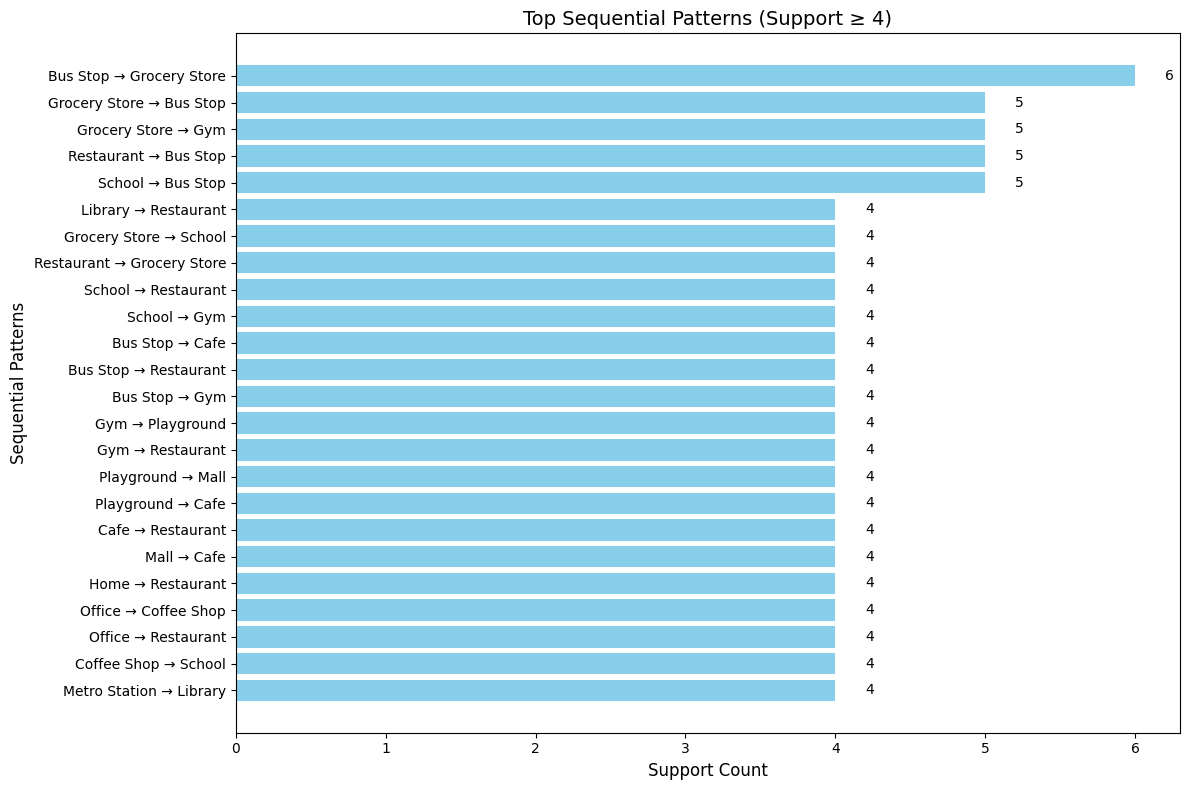

In [31]:
import matplotlib.pyplot as plt

# Extract sequences and their support for plotting
sequences = [' → '.join(seq) for _, seq in top_k_or_more]
supports = [support for support, _ in top_k_or_more]

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(sequences, supports, color='skyblue')
plt.xlabel("Support Count", fontsize=12)
plt.ylabel("Sequential Patterns", fontsize=12)
plt.title(f"Top Sequential Patterns (Support ≥ {threshold_support})", fontsize=14)
plt.gca().invert_yaxis()  # Highest support on top

# Optional: add support values at the end of each bar
for bar, support in zip(bars, supports):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, str(support), va='center')

plt.tight_layout()
plt.show()


In [53]:
# Function to check for closed patterns
def is_closed(pattern, patterns):
    """
    Check if the given pattern is closed. A pattern is closed if no superset has the same support.
    """
    for sup in patterns:
        if len(sup[1]) > len(pattern[1]) and set(pattern[1]).issubset(sup[1]):
            if sup[0] == pattern[0]:  # Same support, hence not closed
                return False
    return True

# Step 1: Filter closed patterns from top_k_or_more
closed_patterns = [p for p in top_k_or_more if is_closed(p, top_k_or_more)]

# Step 2: Print the result
print(f"Closed patterns with support ≥ {threshold_support} (K={K} cutoff):\n")
for support, sequence in closed_patterns:
    print(f"Support: {support} | Sequence: {sequence}")


Closed patterns with support ≥ 4 (K=10 cutoff):

Support: 6 | Sequence: ['Bus Stop', 'Grocery Store']
Support: 5 | Sequence: ['Grocery Store', 'Bus Stop']
Support: 5 | Sequence: ['Grocery Store', 'Gym']
Support: 5 | Sequence: ['Restaurant', 'Bus Stop']
Support: 5 | Sequence: ['School', 'Bus Stop']
Support: 4 | Sequence: ['Library', 'Restaurant']
Support: 4 | Sequence: ['Grocery Store', 'School']
Support: 4 | Sequence: ['Restaurant', 'Grocery Store']
Support: 4 | Sequence: ['School', 'Restaurant']
Support: 4 | Sequence: ['School', 'Gym']
Support: 4 | Sequence: ['Bus Stop', 'Cafe']
Support: 4 | Sequence: ['Bus Stop', 'Restaurant']
Support: 4 | Sequence: ['Bus Stop', 'Gym']
Support: 4 | Sequence: ['Gym', 'Playground']
Support: 4 | Sequence: ['Gym', 'Restaurant']
Support: 4 | Sequence: ['Playground', 'Mall']
Support: 4 | Sequence: ['Playground', 'Cafe']
Support: 4 | Sequence: ['Cafe', 'Restaurant']
Support: 4 | Sequence: ['Mall', 'Cafe']
Support: 4 | Sequence: ['Home', 'Restaurant']
Suppor

In [29]:
prefixspan_patterns = filtered_patterns  # Already sorted and filtered

##GSP

In [14]:
import pickle

# Load the list of sequences
with open("all_sequences.pkl", "rb") as f:
    sequences_list = pickle.load(f)


In [15]:
from itertools import combinations, product
from collections import defaultdict

def get_frequent_1_seq(sequences, min_support):
    freq = defaultdict(int)
    for seq in sequences:
        for item in set(seq):
            freq[(item,)] += 1
    return {k: v for k, v in freq.items() if v >= min_support}

def has_infrequent_subseq(candidate, prev_freq_k):
    k = len(candidate)
    subseqs = [candidate[:i] + candidate[i+1:] for i in range(k)]
    return any(sub not in prev_freq_k for sub in subseqs)

def generate_candidates(prev_freq_k):
    items = set(i for seq in prev_freq_k for i in seq)
    candidates = [a + (b,) for a in prev_freq_k for b in items if a[-1] != b]
    return [c for c in candidates if not has_infrequent_subseq(c, prev_freq_k)]

def is_subsequence(subseq, sequence):
    it = iter(sequence)
    return all(item in it for item in subseq)

def count_support(sequences, candidates):
    freq = defaultdict(int)
    for seq in sequences:
        for cand in candidates:
            if is_subsequence(cand, seq):
                freq[cand] += 1
    return freq

def gsp(sequences, min_support):
    freq_patterns = {}
    k = 1
    Lk = get_frequent_1_seq(sequences, min_support)
    freq_patterns.update(Lk)

    while Lk:
        candidates = generate_candidates(list(Lk))
        support_counts = count_support(sequences, candidates)
        Lk = {k: v for k, v in support_counts.items() if v >= min_support}
        freq_patterns.update(Lk)
        k += 1
    return freq_patterns


In [20]:
min_support = 3  # You can adjust this
patterns = gsp(sequences_list, min_support)

# Display the results
for pattern, support in sorted(patterns.items(), key=lambda x: (-len(x[0]), -x[1])):
    if len(pattern) >= 2:
        print(f"Support: {support} | Pattern: {pattern}")


Support: 6 | Pattern: ('Bus Stop', 'Grocery Store')
Support: 5 | Pattern: ('Restaurant', 'Bus Stop')
Support: 5 | Pattern: ('School', 'Bus Stop')
Support: 5 | Pattern: ('Grocery Store', 'Bus Stop')
Support: 5 | Pattern: ('Grocery Store', 'Gym')
Support: 4 | Pattern: ('Library', 'Restaurant')
Support: 4 | Pattern: ('Grocery Store', 'School')
Support: 4 | Pattern: ('Gym', 'Playground')
Support: 4 | Pattern: ('Cafe', 'Restaurant')
Support: 4 | Pattern: ('Home', 'Restaurant')
Support: 4 | Pattern: ('Office', 'Coffee Shop')
Support: 4 | Pattern: ('Coffee Shop', 'School')
Support: 4 | Pattern: ('Bus Stop', 'Cafe')
Support: 4 | Pattern: ('School', 'Restaurant')
Support: 4 | Pattern: ('Office', 'Restaurant')
Support: 4 | Pattern: ('Playground', 'Mall')
Support: 4 | Pattern: ('Gym', 'Restaurant')
Support: 4 | Pattern: ('Restaurant', 'Grocery Store')
Support: 4 | Pattern: ('Bus Stop', 'Restaurant')
Support: 4 | Pattern: ('Bus Stop', 'Gym')
Support: 4 | Pattern: ('Metro Station', 'Library')
Suppo

In [23]:
# Assuming 'patterns' is the dictionary from your previous code
gsp_patterns = []
for pattern, support in sorted(patterns.items(), key=lambda x: (-len(x[0]), -x[1])):
    if len(pattern) >= 2:
        gsp_patterns.append((support, pattern))  # Store as (support, pattern) tuples

# Now gsp_patterns is a list of (support, pattern) tuples

# To save the list to a file (e.g., 'gsp_patterns.pkl'):
import pickle
with open("gsp_patterns.pkl", "wb") as f:
    pickle.dump(gsp_patterns, f)

# To load it back later:
with open("gsp_patterns.pkl", "rb") as f:
    gsp_patterns = pickle.load(f)

##SPADE

In [5]:
import pickle

# Step 1: Load the saved sequences from the pickle file
with open("all_sequences.pkl", "rb") as f:
    all_sequences = pickle.load(f)

# Step 2: Extract unique items (locations) from all_sequences
all_items = set()
for seq in all_sequences:
    all_items.update(seq)

# Convert to a sorted list (to keep a consistent order)
all_items = sorted(list(all_items))

# Step 3: Create a mapping of items to columns (item -> column_index)
item_to_index = {item: idx for idx, item in enumerate(all_items)}

# Step 4: Create a dictionary where key is item, and value is the set of sequence indices containing that item
item_sequences = {item: set() for item in all_items}

for seq_idx, seq in enumerate(all_sequences):
    for item in seq:
        item_sequences[item].add(seq_idx)

# Print the result with sequence indices in ascending order
for item, seq_indices in item_sequences.items():
    # Convert the set to a sorted list to ensure ascending order
    print(f"{item}: {sorted(seq_indices)}")


Bus Stop: [0, 4, 7, 8, 12, 13, 17, 18, 22, 25, 27, 32, 45, 47, 49, 51, 53, 59, 60, 61, 63, 64, 67]
Cafe: [2, 4, 5, 7, 14, 22, 24, 26, 28, 33, 35, 39, 41, 42, 43, 53, 54, 59, 60, 66, 67]
Coffee Shop: [3, 5, 6, 15, 19, 20, 23, 28, 30, 32, 39, 40, 42, 44, 49, 50, 55, 56, 57, 60, 66]
Grocery Store: [0, 12, 16, 17, 25, 27, 32, 35, 45, 48, 53, 58, 61, 62, 64, 67]
Gym: [1, 5, 10, 14, 16, 18, 24, 27, 30, 32, 38, 51, 52, 55, 57, 58, 62, 65]
Home: [2, 9, 10, 13, 18, 23, 25, 28, 41, 43, 44, 51, 52, 57, 64]
Library: [0, 6, 11, 18, 20, 21, 27, 31, 34, 42, 43, 46, 52, 60, 62, 63, 66]
Mall: [2, 8, 10, 11, 24, 26, 29, 34, 37, 43, 44, 45, 54, 59, 64, 65]
Metro Station: [5, 8, 9, 14, 15, 17, 21, 22, 36, 42, 50, 52, 58, 63]
Office: [3, 7, 9, 14, 16, 25, 26, 30, 38, 42, 47, 55, 56, 59, 63]
Playground: [1, 6, 8, 10, 11, 14, 16, 21, 24, 26, 31, 33, 35, 37, 44, 53, 60, 61]
Restaurant: [0, 2, 7, 13, 16, 17, 21, 25, 27, 28, 29, 33, 35, 37, 39, 40, 46, 48, 49, 51, 52, 55, 63, 65]
School: [0, 3, 5, 7, 18, 19, 23

In [25]:
min_support = 3  # you can change this as needed

frequent_1_seq = {
    item: seq_ids
    for item, seq_ids in item_sequences.items()
    if len(seq_ids) >= min_support
}


In [26]:
from collections import defaultdict

frequent_2_seq = []

for item1 in frequent_1_seq:
    for item2 in frequent_1_seq:
        if item1 == item2:
            continue

        support_count = 0

        for sid in item_sequences[item1] & item_sequences[item2]:  # common sequences
            seq = all_sequences[sid]

            try:
                pos1 = seq.index(item1)
                pos2 = seq.index(item2)
                if pos1 < pos2:
                    support_count += 1
            except ValueError:
                continue

        if support_count >= min_support:
            frequent_2_seq.append((support_count, (item1, item2)))


In [27]:
frequent_2_seq = sorted(frequent_2_seq, key=lambda x: x[0], reverse=True)

print("Frequent 2-sequences (SPADE):")
for support, pattern in frequent_2_seq:
    print(f"Support: {support} | Pattern: {pattern}")


Frequent 2-sequences (SPADE):
Support: 6 | Pattern: ('Bus Stop', 'Grocery Store')
Support: 5 | Pattern: ('Grocery Store', 'Bus Stop')
Support: 5 | Pattern: ('Grocery Store', 'Gym')
Support: 5 | Pattern: ('Restaurant', 'Bus Stop')
Support: 5 | Pattern: ('School', 'Bus Stop')
Support: 4 | Pattern: ('Bus Stop', 'Cafe')
Support: 4 | Pattern: ('Bus Stop', 'Gym')
Support: 4 | Pattern: ('Bus Stop', 'Restaurant')
Support: 4 | Pattern: ('Cafe', 'Restaurant')
Support: 4 | Pattern: ('Coffee Shop', 'School')
Support: 4 | Pattern: ('Grocery Store', 'School')
Support: 4 | Pattern: ('Gym', 'Playground')
Support: 4 | Pattern: ('Gym', 'Restaurant')
Support: 4 | Pattern: ('Home', 'Restaurant')
Support: 4 | Pattern: ('Library', 'Restaurant')
Support: 4 | Pattern: ('Mall', 'Cafe')
Support: 4 | Pattern: ('Metro Station', 'Library')
Support: 4 | Pattern: ('Office', 'Coffee Shop')
Support: 4 | Pattern: ('Office', 'Restaurant')
Support: 4 | Pattern: ('Playground', 'Cafe')
Support: 4 | Pattern: ('Playground', 

In [30]:
spade_patterns = frequent_2_seq  # Already sorted

In [31]:
# Convert sequences to tuples (in case they aren't already)
prefixspan_set = set(tuple(p[1]) for p in prefixspan_patterns)
gsp_set = set(tuple(p[1]) for p in gsp_patterns)
spade_set = set(tuple(p[1]) for p in spade_patterns)


In [32]:
# Overlaps
print("PrefixSpan ∩ GSP:", prefixspan_set & gsp_set)
print("PrefixSpan ∩ SPADE:", prefixspan_set & spade_set)
print("GSP ∩ SPADE:", gsp_set & spade_set)

# Unique patterns
print("\nUnique to PrefixSpan:", prefixspan_set - (gsp_set | spade_set))
print("Unique to GSP:", gsp_set - (prefixspan_set | spade_set))
print("Unique to SPADE:", spade_set - (prefixspan_set | gsp_set))


PrefixSpan ∩ GSP: {('Grocery Store', 'Restaurant'), ('Coffee Shop', 'Cafe'), ('Mall', 'Home'), ('Library', 'Gym'), ('Library', 'Bus Stop'), ('School', 'Restaurant'), ('School', 'Home'), ('Grocery Store', 'School'), ('Playground', 'Grocery Store'), ('Restaurant', 'Coffee Shop'), ('Coffee Shop', 'Library'), ('Office', 'Metro Station'), ('Mall', 'Playground'), ('Office', 'Restaurant'), ('Cafe', 'Coffee Shop'), ('Bus Stop', 'Home'), ('Bus Stop', 'Office'), ('Bus Stop', 'Restaurant'), ('Gym', 'Coffee Shop'), ('Metro Station', 'Library'), ('Restaurant', 'Bus Stop'), ('Metro Station', 'Bus Stop'), ('Cafe', 'Bus Stop'), ('Home', 'Cafe'), ('Bus Stop', 'School'), ('Playground', 'Restaurant'), ('Restaurant', 'Grocery Store'), ('Library', 'Restaurant'), ('Mall', 'Cafe'), ('Cafe', 'Grocery Store'), ('School', 'Coffee Shop'), ('Home', 'Gym'), ('Office', 'Cafe'), ('Office', 'Coffee Shop'), ('Grocery Store', 'Bus Stop'), ('Grocery Store', 'Gym'), ('Playground', 'Mall'), ('Bus Stop', 'Cafe'), ('School'

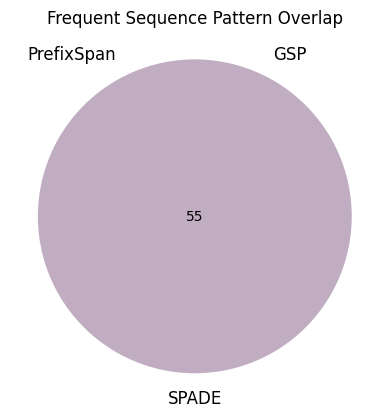

In [33]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

venn3([prefixspan_set, gsp_set, spade_set],
      set_labels=("PrefixSpan", "GSP", "SPADE"))
plt.title("Frequent Sequence Pattern Overlap")
plt.show()
